# S3E24 Notebook - Column datatypes and SMOTE
* version this: add the gender prediction model.
* Try SMOTE
    * CV Scores go up to .89-.9, why?

# Installs

In [60]:
#!pip install -q scienceplots
#!pip install -q catboost
#!pip install optuna

# Imports

In [61]:
import os, glob, pathlib
import pickle
import joblib

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
#import plotly.express as px

import scienceplots
plt.style.use(['science','no-latex'])  # not sure how to set up latex in kaggle yet.

import warnings
warnings.filterwarnings('ignore')

import optuna
from optuna.samplers import TPESampler

# Read Data

In [62]:
psg = True

if psg:
    root_dir = '.'
else:
    root_dir = '/kaggle/input/playground-series-s3e24'
    
train = pd.read_csv(root_dir + '/train.csv')
test = pd.read_csv(root_dir + '/test.csv')
ss = pd.read_csv(root_dir + '/sample_submission.csv')

In [63]:
all_features = [col for col in test.columns if col !='id']
int_features = [col for col in test.columns if 'id' not in col and test[col].dtype=='int']
float_features = [col for col in test.columns if test[col].dtype=='float']

features = all_features
features

['age',
 'height(cm)',
 'weight(kg)',
 'waist(cm)',
 'eyesight(left)',
 'eyesight(right)',
 'hearing(left)',
 'hearing(right)',
 'systolic',
 'relaxation',
 'fasting blood sugar',
 'Cholesterol',
 'triglyceride',
 'HDL',
 'LDL',
 'hemoglobin',
 'Urine protein',
 'serum creatinine',
 'AST',
 'ALT',
 'Gtp',
 'dental caries']

## Feature Engineering

### Add M/F predictions

In [64]:
#model_gndr = joblib.load('/kaggle/input/s3e24-gender-prediction-model/rf_gender_prediction.joblib')
model_gndr = joblib.load(root_dir + '/xgb_gndr_model.joblib')

train_gndr = model_gndr.predict_proba(train[features])[:,1]
test_gndr = model_gndr.predict_proba(test[features])[:,1]

In [65]:
train['gender'] = train_gndr.round().astype('int')
test['gender'] = test_gndr.round().astype('int')


In [66]:
# add to features arrays
features.append('gender')

In [67]:
train[features].head(10)

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,gender
0,55,165,60,81.0,0.5,0.6,1,1,135,87,94,172,300,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,147,194,55,57,126,16.2,1,1.1,27,23,37,1,1
2,20,170,75,81.0,0.4,0.5,1,1,118,75,79,178,197,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,91,180,203,38,102,15.9,1,1.0,20,27,30,1,1
4,30,165,60,80.5,1.5,1.0,1,1,121,76,91,155,87,44,93,15.4,1,0.8,19,13,17,0,1
5,50,170,55,51.0,1.2,1.2,1,1,146,95,101,199,343,31,99,15.9,1,0.7,24,42,119,1,1
6,45,160,55,69.0,1.5,1.2,1,1,150,88,84,222,153,69,122,13.0,1,0.7,17,12,16,0,0
7,55,155,60,84.5,0.7,0.9,1,1,137,91,100,282,165,51,198,14.5,1,0.7,16,15,16,0,0
8,40,165,70,89.0,0.7,1.0,1,1,130,80,104,243,163,59,150,15.7,1,0.9,24,21,31,0,1
9,40,155,50,73.0,1.5,1.5,1,1,105,70,64,183,27,55,122,13.2,1,0.7,22,16,14,0,0


In [68]:
# train[train['eyesight(left)'] > 9.0] = 0
# train[train['eyesight(right)'] > 9.0] = 0

# test[test['eyesight(left)'] > 9.0] = 0
# test[test['eyesight(right)'] > 9.0] = 0

In [69]:
# define y variable
y = train['smoking']

x_test = test[features]

## SMOTE

In [70]:
seed=12

from imblearn.over_sampling import SMOTE

smt = SMOTE(random_state=seed, sampling_strategy="minority")
train_smt, labels_smt = smt.fit_resample(train[features], y)



In [71]:

# reshuffle everything
train_smt["smoking"] = labels_smt

train_smt = train_smt.sample(frac=1.0).reset_index(drop=True)
y = train_smt.pop("smoking")



## SMOTE added about 20000 points

## Scaling

In [72]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()
rob_scaler = RobustScaler()

# swap out which scaler you want here (some people scale inside of CV)
train[features] = pd.DataFrame(mm_scaler.fit_transform(train[features]), columns = features)
test[features] = pd.DataFrame(mm_scaler.transform(test[features]), columns = features)


## Cross Validation

In [73]:
from sklearn.model_selection import train_test_split, StratifiedKFold

folds = 5
seed = 12

In [74]:
# if continuous, change predict_proba to predict
def run_cv_and_predict(train, test, features, model, seed,verbose=False):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)
    # Use KFold if target is continuous
    #skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = roc_auc_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
            print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])[:,1]
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = roc_auc_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'ROC AUC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

# Models

In [75]:
from sklearn.linear_model import LogisticRegression   # try CV too
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


## Split Data

## Baseline Model - Logistic Regression

In [76]:
model_lr = LogisticRegression()#C=10)
preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train_smt,test,features,model_lr,seed)


# model.fit(x_train,y_train)
# val_preds = model.predict_proba(x_valid)[:,1]  
# score = roc_auc_score(y_valid, val_preds)   # make sure true is first
# print(f'ROC AUC Score = {score:.5f}')


# default lr, no feature engineering, all features, tts = .81622, lb = .81916
# int features = .80181, lb = .80703
# float features = .76748, lb = .77048
# cross validation: .81702, lb = 
# std scaling helped logreg by alot! = .83371
# add gender feature: .84207
# better sex preds: .84197

ROC AUC score: 0.82428, Stdev: 0.00387, OOF score: 0.82427


## Plot ROC Curve

In [77]:
# plt.figure(figsize=(5,3.5))
# fpr,tpr,_ = roc_curve(y,oof_lr)
# plt.plot(fpr,tpr, label=f'AUC = {np.mean(scores_lr):.5}')
# plt.legend(loc='lower right')
# plt.title('ROC AUC Score for Logistic Regression')
# plt.show()

## Catboost
* About 2x speed of RF with current config, 2 min run time

In [78]:
%%time
from catboost import CatBoostClassifier



# results = []
# for iters in [500,750,1000,1250,1500]:
#     for d in [3,5,6,7,9]:
#         for lr in [.001,.005,.01,.025,.05,.1]:
#             model_cat = CatBoostClassifier(verbose=0, 
#                                            iterations=iters,
#                                            depth=d,
#                                            learning_rate=lr,
#                                            task_type='GPU')
#             print(f'iters: {iters}, d: {d}, lr: {lr}')
#             preds_cat, scores_cat, oof_score_cat, oof_cat = run_cv_and_predict(train,test,features,model_cat,seed,verbose=False)
#             results.append([iters,d,lr, np.mean(scores_cat),oof_score_cat])

# default ROC AUC score: 0.86531, Stdev: 0.00177, OOF score: 0.86529, lb = 
# 2 min run time

# add gender feature, 1000,.025,6, score = .86874, lb = .87257

# best optimization model: 1500,5,0.1, cv = 0.86845, oof = 0.86844  ( a bit lower than before

CPU times: user 150 ms, sys: 229 ms, total: 379 ms
Wall time: 93.6 ms


In [79]:
# results_df = pd.DataFrame(results,columns=['iterations','depth','learning_rate','cv_score','oof_score'])
# results_df.head()

In [80]:
# best_row = results_df[results_df.cv_score == max(results_df.cv_score)]
# print(best_row)

In [81]:
!pip install plotly

In [82]:
# import plotly.express as px

# # plotly 3d surface
# fig = px.scatter_3d(results_df, x='iterations', y='depth', z='learning_rate',color='cv_score',
#                    title='Score vs hyperparams')  # scatter of 3 cols of df
# #fig.update_traces(marker={'size': 4})  # scene=dict(zaxis=dict(range=[-5, 5]))
# fig.show(renderer='notebook')

# plotly doesn't show up in gradient


### Use static matplotlib since plotly not working

In [83]:
# import re, seaborn as sns
# import numpy as np

# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
# sns.set_style('whitegrid')

# # axes instance
# fig = plt.figure(figsize=(6,6))
# ax = Axes3D(fig, auto_add_to_figure=False)
# fig.add_axes(ax)

# # get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("viridis", 256).as_hex())

# # plot
# sc = ax.scatter(results_df.iterations, results_df.depth, results_df.learning_rate, s=40, c=results_df.cv_score, marker='o', cmap=cmap, alpha=1)
# ax.set_xlabel('Iterations')
# ax.set_ylabel('Depth')
# ax.set_zlabel('Learning Rate')

# # legend
# plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# # save
# plt.savefig("scatter_hue", bbox_inches='tight')

## Catboost with Optuna

In [84]:

def objective(trial):
    
    scores = []
    
    param_grid = {
        'learning_rate': trial.suggest_float('learning_rate', 5e-2, 2e-1),
        'n_estimators': trial.suggest_int('n_estimators', 500,2000),
        'depth': trial.suggest_categorical('depth', [3,5,7,9,11,13,15]),
        #"subsample": trial.suggest_float("subsample", 0.05, 1.0),
        #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    
    #model = XGBClassifier(**param_grid,tree_method="gpu_hist") #tree_method='hist',device='cuda')
    model = CatBoostClassifier(**param_grid,
                                verbose=0,
                               task_type='GPU')
    
    # do cross validation - 5 folds
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_score = roc_auc_score(y_valid,fold_preds) 
        scores.append(fold_score)
        #print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
#         test_preds = model.predict_proba(test[features])[:,1]
#         test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
#         preds[:,cur_fold-1] = test_preds 
        
        cur_fold +=1
        
    print(np.mean(scores))

    return np.mean(scores)


In [85]:
# %%time
# # create the study
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# 
# sampler = TPESampler(seed=1)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=10)

In [86]:
# # evaluate the trial
# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# best_trial = study.best_trial
# print("  Value: ", best_trial.value)
# print("  Params: ")
# for key, value in best_trial.params.items():
#     print("    {}: {}".format(key, value))


In [87]:
print('test')

test


In [88]:
# load trained model
# model_cat = pickle.load(open('/kaggle/input/s3e24-saved-models/catboost_optuna2.pkl', 'rb'))
# preds_cat = model_cat.predict_proba(x_test)[:,1]

## XGBoost

In [89]:
#set1_params = {}

In [90]:
%%time

# # set 1
# model_xgb = XGBClassifier(#lambda=1.9550993816120785,
#                           alpha= 5.814007913805305,
#                           colsample_bytree= 0.3,
#                           subsample= 1.0,
#                           learning_rate= 0.0583947767053339,
#                           n_estimators= 1070,
#                           max_depth= 7,
#                           min_child_weight= 64,
#                           random_seed=seed,
#                          )


# set 2
model_xgb = XGBClassifier(#lambda=1.9550993816120785,
                      alpha= 4.632016934249366,
                      colsample_bytree= 0.3,
                      subsample= 1.0,
                      learning_rate= 0.06313783399677664,
                      n_estimators= 1136,
                      max_depth= 7,
                      min_child_weight= 53,
                      random_state=seed
                     )

# # set 3
# model_xgb = XGBClassifier(#lambda=1.9550993816120785,
#                       alpha= 7.061,
#                       colsample_bytree= 0.3,
#                       subsample= 0.8,
#                       learning_rate= 0.03416,
#                       n_estimators= 1874,
#                       max_depth= 7,
#                       min_child_weight= 37,
#                       random_state=seed
#                      )


# model_xgb = XGBClassifier(max_depth=4, n_estimators=100, learning_rate=.35)

# print(f'learning rate: {lr}')
# 
# preds_xgb, scores_xgb, oof_score_xgb, oof_xgb = run_cv_and_predict(train_smt,test,features,model_xgb,seed,verbose=True)

# default, ROC AUC score: 0.86121, Stdev: 0.00183, OOF score: 0.86118, lb = .86831
# tuning, higher estimators  = decreasing results.  Try just 50, currently 100 is the highest
# max depth of 4 is .86147 (highest of 3-9)
# lr .1 to .5, highest is .35 at .86160


# Optuna run 1: ROC AUC score: 0.86783, Stdev: 0.00167, OOF score: 0.86782
# eyesight >9.0 = 0.0, ROC AUC score: 0.86798, Stdev: 0.00245, OOF score: 0.86796

# eyesight thing off, std scaler, ROC AUC score: 0.86783, Stdev: 0.00167, OOF score: 0.86782, lb = .87136
# eyesight off, mm scaler: tad worse

# add gender feature, no eye correction
# set 1 hp's: cv = .87247, lb = .87587
# set 2 hp's: cv = .87280, lb = .87623
# set 3 hp's: cv = .87304, lb = .87610

# use better model for sex
# set 1 hp's: cv = 0.87255
# set 2 hp's: cv = 

CPU times: user 583 µs, sys: 953 µs, total: 1.54 ms
Wall time: 1.39 ms


## Train Full model with different random seeds and average results

In [91]:
# %%time
# results = []


# for i in range(10):
    
# define the model
# model_xgb = XGBClassifier(#lambda=1.9550993816120785,
#                       alpha= 4.632016934249366,
#                       colsample_bytree= 0.3,
#                       subsample= 1.0,
#                       learning_rate= 0.06313783399677664,
#                       n_estimators= 1136,
#                       max_depth= 7,
#                       min_child_weight= 53,
#                       random_state=i
#                      )


    
#     # fit the model on the whole dataset
#     model_xgb.fit(train[features],y)
#     # make predictions
#     results.append(model_xgb.predict_proba(x_test)[:,1])
    
# preds_xgb_full = np.mean(results,axis=0)

    
# 11/02/23 New params, score = .86798


## LightGBM
* super fast ~= 40 sec

In [92]:
# %%time
from lightgbm import LGBMClassifier

# # best params so far:
# est = 1000
# lr = .02
# d = 3

# # results = []

# # for i in range(10):
# model_lgbm = LGBMClassifier(n_estimators=est,
#                             learning_rate=lr,
#                             max_depth=d,
#                             random_state=seed,
#                             )
    

# #     # now that tuned fit the model on the whole dataset
# #     model_lgbm.fit(train[features],y)
    
# #     # make predictions
# #     results.append(model_lgbm.predict_proba(x_test)[:,1])
    
# # preds_lgbm_full = np.mean(results,axis=0)

# preds_lgbm, scores_lgbm, oof_score_lgbm, oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,seed,verbose=True)

# default: ROC AUC score: 0.86130, Stdev: 0.00173, OOF score: 0.86128,
# default 100 to 200 est: .86253
# 200 to 400 est: .86307
# 1000,.02,3, score = .86534

# add gender feat, cv = .86353

In [93]:

def objective(trial):

    scores = []

    lgbm_params = {'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
                   'max_depth': trial.suggest_int('max_depth', 20,100),
                   'learning_rate': trial.suggest_float('learning_rate', 5e-3, 2e-1),
                   'min_child_weight': trial.suggest_float('min_child_weight',1.0,5.0),
                   'min_child_samples': trial.suggest_int('min_child_samples',100,400),
                   'subsample': trial.suggest_float('subsample',0.3,1.0),
                   'subsample_freq': trial.suggest_int('subsample_freq',3,20),
                   'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,1.00),
                   'num_leaves': trial.suggest_int('num_leaves',5,120),
                   }

    model=LGBMClassifier(**lgbm_params,random_state=seed,verbose=-1)

    # do cross validation - 5 folds
    skf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train_smt, y):
        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train, y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:, 1]
        fold_score = roc_auc_score(y_valid, fold_preds)
        scores.append(fold_score)
        #print(f'ROC AUC Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        #         test_preds = model.predict_proba(test[features])[:,1]
        #         test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        #         preds[:,cur_fold-1] = test_preds 

        cur_fold += 1

    print(np.mean(scores))

    return np.mean(scores)


In [94]:
%%time
# create the study
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="lightgbm", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=500)

[W 2023-11-09 15:06:27,464] Trial 0 failed with parameters: {'n_estimators': 1125, 'max_depth': 78, 'learning_rate': 0.005022303089382253, 'min_child_weight': 2.209330290527359, 'min_child_samples': 144, 'subsample': 0.3646370163381584, 'subsample_freq': 6, 'colsample_bytree': 0.4764485816344382, 'num_leaves': 51} because of the following error: IndexError('positional indexers are out-of-bounds').
Traceback (most recent call last):
  File "/home/jon/mambaforge/envs/dataspell/lib/python3.8/site-packages/pandas/core/indexing.py", line 1618, in _get_list_axis
    return self.obj._take_with_is_copy(key, axis=axis)
  File "/home/jon/mambaforge/envs/dataspell/lib/python3.8/site-packages/pandas/core/generic.py", line 3948, in _take_with_is_copy
    result = self._take(indices=indices, axis=axis)
  File "/home/jon/mambaforge/envs/dataspell/lib/python3.8/site-packages/pandas/core/generic.py", line 3932, in _take
    new_data = self._mgr.take(
  File "/home/jon/mambaforge/envs/dataspell/lib/pyth

IndexError: positional indexers are out-of-bounds

In [95]:
# est = results_np[:,0]
# lr = results_np[:,1]
# md = results_np[:,2]
# score = results_np[:,4]

In [96]:
# results_df = pd.DataFrame(est,columns=['estimators'])
# results_df['learning_rate'] = lr
# results_df['max_depth'] = md
# results_df['score'] = score

# results_df.head()

In [97]:
# results_df[results_df.score == np.max(results_df.score)]
# max at 144: est 1000, lr = .02, md = 3, score = .86534

In [98]:
# results_df.to_csv('lgbm_tune1.csv')

# Ensemble

In [99]:
# import plotly.express as px
# import random

# # model 1
# model1 = oof_cat
# preds_1 = preds_cat

# # models 2
# model2 = oof_xgb
# preds_2 = preds_xgb

# # model 3
# model3 = oof_lgbm
# preds_3 = preds_lgbm

# # model 4
# # model4 = oof_hgbc_ens
# # preds_4 = hgbc_preds

# # model 5
# # model5 = oof_lr
# # preds_5 = preds_lr

# # generate a random mix for a stochastic determination of min
# m = []
# for i in range(1000):
#     # Generate 3 random numbers to make a mix
#     a,b,c = random.random(),random.random(),random.random() #, random.random(),random.random()
#     total = a + b + c #+ d# + e
#     a /= total
#     b /= total
#     c /= total
# #     d /= total
# #     e /= total
    
#     tm_ens = a*model1 + b*model2 + c*model3 # + d*model4# + e*model5
#     tm_score = roc_auc_score(y,tm_ens)  # swap out error function here
#     m.append([a,b,c, tm_score])
    
    
# three_model = pd.DataFrame(m,columns=['a','b','c','score'])
# three_model.head()

# # find min/max score
# max_row = three_model[three_model.score == three_model.score.max()]

# # get ratios
# ratio1 = max_row.a.values[0]
# ratio2 = max_row.b.values[0]
# ratio3 = max_row.c.values[0]
# # ratio4 = max_row.d.values[0]
# #ratio5 = max_row.e.values[0]

# # predictions on test set
# preds_ens = ratio1*preds_1 + \
#             ratio2*preds_2 + \
#             ratio3*preds_3 # + \
# #             ratio4*preds_4 + \
# #            ratio5+preds_5.mean(axis=1)


# oof_3_model_ens = ratio1*oof_cat + ratio2*oof_xgb + ratio3*oof_lgbm # + ratio4*oof_hgbc_ens
# score = roc_auc_score(y,oof_3_model_ens)
# print(f'OOF score of ensemble: {score}')

## Plot Results

In [100]:
# # plotly 3d surface
# fig = px.scatter_3d(three_model, x='a', y='b', z='c',color='score',
#                    title='Score vs ratios for 3 model ensemble')  # scatter of 3 cols of df
# fig.update_traces(marker={'size': 4})  # scene=dict(zaxis=dict(range=[-5, 5]))
# fig.show(renderer='notebook')

## Voting Classifier

In [101]:

# voting_classifier = VotingClassifier(estimators=[
#     ('catboost', model_cat),
#     ('lgbm', model_lgbm),
#     ('xgb', model_xgb)
# ], voting='soft')

# # voting_classifier.fit(train, y)
# # y_pred = voting_classifier.predict(val_X)
# # auroc_score = roc_auc_score(val_Y, y_pred)
# # print(f"AUC-ROC score on validation set: {auroc_score}")

# cv_scores = cross_val_score(voting_classifier, train[features], y, cv=5, scoring='roc_auc')

# print("Cross-validation scores:", cv_scores)
# print("Mean AUC-ROC score:", np.mean(cv_scores))

In [102]:
# voting_classifier.fit(train[features], y)
# voting_preds = voting_classifier.predict_proba(x_test[features])[:, 1]

# ['smoking'] = test_preds.tolist()


### Potential Visualization Improvements
* rotate plane to coincide with the z=0 plane, like PCA
* stack planes with transparency to get another visualization dimensions

In [103]:
# three_model.head()

In [104]:
# # sort values so best scores are on the top
# sorted_3m = three_model.sort_values(by='score',ascending=False)

# # take the mean ratios of the top 10 results
# a = sorted_3m.a[0:10].mean()
# b = sorted_3m.b[0:10].mean()
# c = sorted_3m.c[0:10].mean()
# #d = sorted_3m.d[0:10].mean()

# tot = a + b + c #+ d

# # make a prediction using the average of the top 10 ratios
# preds_ens = (a/tot)*preds_1.mean(axis=1) + (b/tot)*preds_2.mean(axis=1) + (c/tot)*preds_3.mean(axis=1) # + (d/tot)*preds_4  

# oof_3_model_ens = (a/tot)*oof_cat + (b/tot)*oof_xgb + (c/tot)*oof_lgbm # + (d/tot)*oof_hgbc_ens
# score = roc_auc_score(y,oof_3_model_ens)
# print(f'OOF score of ensemble: {score:.5f}')


# Chose Predictions and Submit Results

In [105]:
# preds = (preds_xgb_full + preds_lgbm_full)/2
preds = preds_xgb.mean(axis=1) # + preds_cat)/2
#preds = voting_preds
preds

array([0.11671548, 0.11671548, 0.11671548, ..., 0.12761154, 0.03592716,
       0.04095039])

In [106]:
ss.smoking = preds
ss.to_csv('submission.csv',index=False)
ss.head(3)

,id,smoking
0,159256,0.116715
1,159257,0.116715
2,159258,0.116715


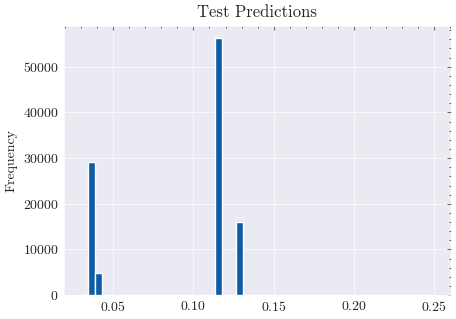

In [107]:
plt.figure(figsize=(5,3.5))
ss.smoking.plot(kind='hist',bins=50)
plt.title('Test Predictions');